# CNN Image Classifier

## Installing Dependencies and Setup

In this project, TensorFlow is used. To run the image classification models on the GPU for faster execution, tensorflow-gpu is installed. However, TensorFlow started integrating GPU support directly into the main package from version 2.0 onwards therefore for this project, TensorFlow version 2.8 (which includes GPU support) was used.

In [473]:
pip install tensorflow==2.8 tensorflow-gpu==2.8 opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\FA507RM\ImageClassifcation\imageclassification\Scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
import tensorflow as tf
import os

In [3]:
#To avoid Out Of Memory errors we set GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices("GPU") #Printing available GPU's

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Removing Dodgy Images

The images may not open in Python because they might be corrupted, mislabeled, or have the incorrect extension applied.

-- Corrupted Images:
Corrupted files might not load correctly, resulting in errors during data loading or model training. If the model tries to process incomplete or damaged images, it could produce inaccurate predictions.

--Mislabeled Images:
Incorrect labels can mislead the classifier during training, making it learn incorrect associations between features and labels. This leads to poor performance and inaccurate predictions.

--Incorrect File Extensions:
File extensions that don't match the actual file format may cause loading errors or incorrect processing. Some image libraries may fail to read the file, while others might load it improperly.

These issues reduce the classifier's accuracy and cause it to give wrong labels. 

In [5]:
import cv2
import imghdr

In [6]:
image_extensions = ["jpeg","jpg","png"]
data_dir = "data"

for category in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, category)):
        path = os.path.join(data_dir, category, image) #The path of an image in categories (One or Three)
        try:
            img = cv2.imread(path)
            tip = imghdr.what(path)
            if tip not in image_extensions:
                print("The format of image {} is wrong" .format(path))
                os.remove(path)
        except Exception as e:
            print("Issue with image {}" .format(path))

## Loading Data


In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
#Resize the images to 256x256 and batches images to 32 as default.
data = tf.keras.utils.image_dataset_from_directory("data") 
data_iterator = data.as_numpy_iterator()

data_batch = data_iterator.next() #Images representes as numpy arrays. 


Found 220 files belonging to 2 classes.


The code below shows us our batches of image and their mutual classes. 
    
    Hand gestures for one (Class One) are represented by 0.
    
    Hand gestures for three (Class Three) are represented by 1.

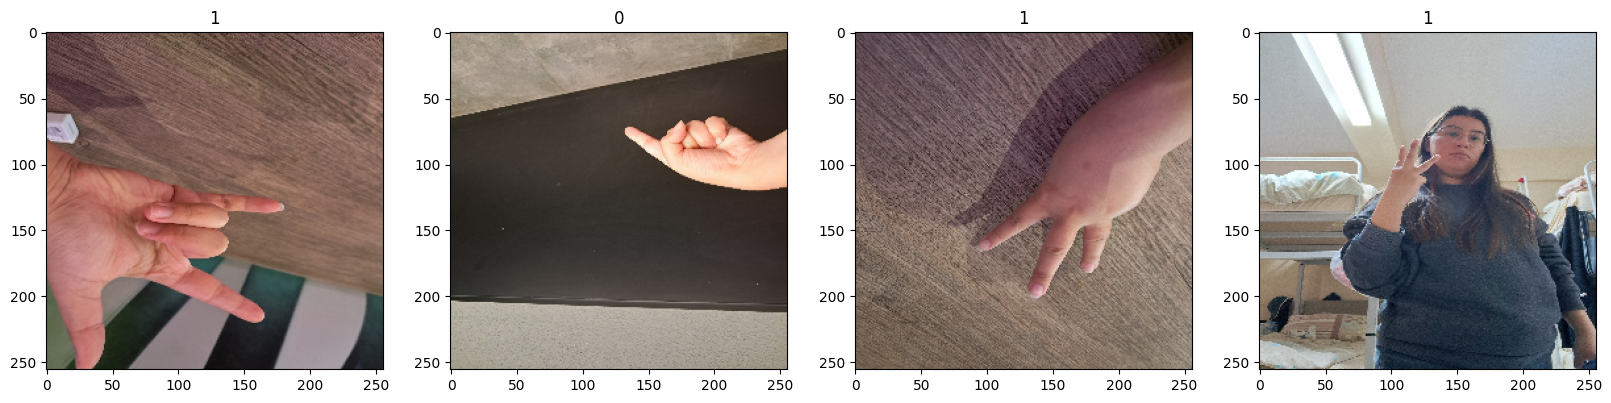

In [9]:
fig,ax = plt.subplots(ncols = 4, figsize = (20,20))

for idx, img in enumerate(data_batch[0][:4]):
    img = tf.image.rot90(img, k=1).numpy() # Rotate 90 degrees counter-clockwise and convert into numpy array
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(data_batch[1][idx])
    

#### Preprocess the data

Image preprocessing is a critical step in image processing that transforms raw image data into a format that is easier for models to process and analyze. In the code below data normalization was performed as part of preprocessing. Normalization scales the pixel values of the images to the range [0, 1], which is a vital step that ensures consistent input data for the model. Data normalization leads to more accurate and steady results.

Found 220 files belonging to 2 classes.


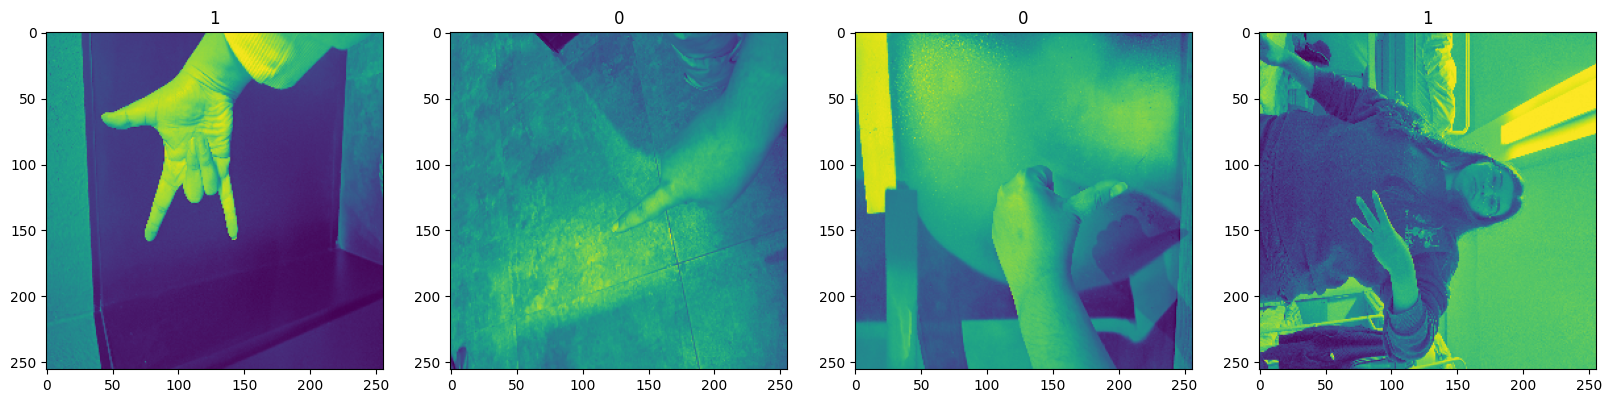

In [71]:
from tensorflow.keras import layers
data = tf.keras.utils.image_dataset_from_directory("data") 
data = data.map(lambda x, y: (x/255.0, y)) #Resize the images

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.1),
])
def augment_images(x, y):
    x = data_augmentation(x)  # Apply augmentation
    return x, y


data = data.map(augment_images)
data = data.map(lambda x,y: (tf.image.rgb_to_grayscale(x),y))
batch = data.as_numpy_iterator().next()

fig,ax = plt.subplots(ncols = 4, figsize = (20,20))

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])


###### The code below separates the training, validation, and test batches. 
The train_size, validation_size, and test_size variables are calculated as proportions of the total dataset (%60, %30, and %10, respectively).

Using data.take() we allocate assigned batches to our training data (size of train_size).
For val and test we skip the batches that are already allocated and take the leftover batches to our val and test data.

In [75]:
print(len(data)) #Gives us the batch number. In this case we have Seven batches

train_size = int(len(data)*.6)
validation_size = int(len(data)*.3)
test_size = int(len(data)*.1)+1

train = data.take(train_size)
val = data.skip(train_size).take(validation_size)
test = data.skip(train_size + validation_size).take(test_size)

7


### Model Creation

The simple CNN model has 2 convolution layers, 2 max-pooling layers, one flatten layer, 2 fully connected layers (dense), and two dropout layers.

Convolution Layer: Creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs. The used parameters of this layer are filter number, filter size, stride, and activation function.

Max-pooling Layer: Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension. The used parameter of this layer is the pool_size.

Fully connected Layer (Dense Layer): Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, the kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True). In this layer, a regularizer function (L2) is also applied to the kernel weights matrix.

Dropout Layer: The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1 / (1 - rate) such that the sum of all inputs is unchanged.

The model is optimized using "adam" and for loss "Binary cross-entropy" is used to measure how well the model's predictions match the actual labels. with metrics, we specify the performance metric(s) to track during training and evaluation.

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
#Dense: Fully connected layer available through keras.
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

model = Sequential()
#Conv2D layer: filter number, filter size, stride
model.add(Conv2D(16, (2,2), 1, activation="relu", input_shape=(256,256,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (2,2), 1, activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

#using 'adam' optimizer
model.compile("adam", loss = tf.losses.BinaryFocalCrossentropy(), metrics = ["accuracy"])

model.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 255, 255, 16)      80        
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 127, 127, 16)      0         
                                                                 
 conv2d_27 (Conv2D)          (None, 126, 126, 32)      2080      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 127008)          

The below code trains the model on the training dataset and validates it on the validation dataset for up to 20 epochs. During this a tensorboard callback logs training and validation metrics to a directory named logs for visualization. An EarlyStopping callback stops training early if the validation loss does not improve for 4 consecutive epochs, potentially reducing overfitting and saving time. 

In [93]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

log_dir = "logs" 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

history = model.fit(train, epochs = 20, validation_data = val, callbacks = [tensorboard_callback, early_stopping])

Epoch 1/20
4/4 [==============================] - 3s 437ms/step - loss: 3.0299 - accuracy: 0.5391 - val_loss: 1.3900 - val_accuracy: 0.6094
Epoch 2/20
4/4 [==============================] - 2s 446ms/step - loss: 1.5440 - accuracy: 0.5234 - val_loss: 0.6903 - val_accuracy: 0.5312
Epoch 3/20
4/4 [==============================] - 2s 423ms/step - loss: 0.8134 - accuracy: 0.5625 - val_loss: 0.6892 - val_accuracy: 0.5469
Epoch 4/20
4/4 [==============================] - 2s 417ms/step - loss: 0.7034 - accuracy: 0.6172 - val_loss: 0.6793 - val_accuracy: 0.7188
Epoch 5/20
4/4 [==============================] - 3s 461ms/step - loss: 0.6682 - accuracy: 0.5547 - val_loss: 0.6498 - val_accuracy: 0.5781
Epoch 6/20
4/4 [==============================] - 2s 423ms/step - loss: 0.6394 - accuracy: 0.5156 - val_loss: 0.6138 - val_accuracy: 0.6562
Epoch 7/20
4/4 [==============================] - 3s 443ms/step - loss: 0.5982 - accuracy: 0.5781 - val_loss: 0.5770 - val_accuracy: 0.4688
Epoch 8/20
4/4 [====

Below we have two graphs that shows the training data, first one shows the loss and validation loss while the other shows the accuracy and validation accuracy.

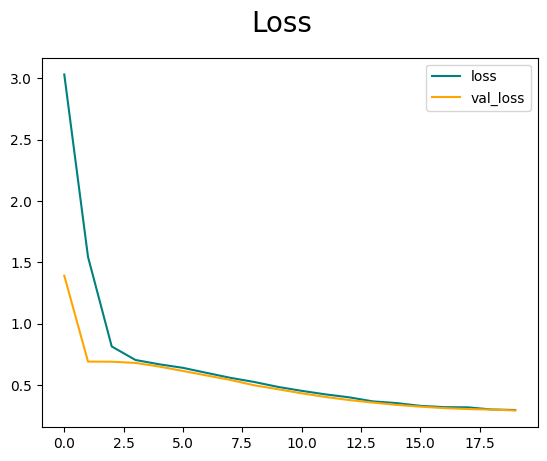

In [94]:
fig = plt.figure() #Creating the graph for loss

plt.plot(history.history["loss"], color = "teal", label= "loss")
plt.plot(history.history["val_loss"], color = "orange", label= "val_loss")
fig.suptitle("Loss", fontsize = 20)
plt.legend(loc = "upper right")
plt.show()

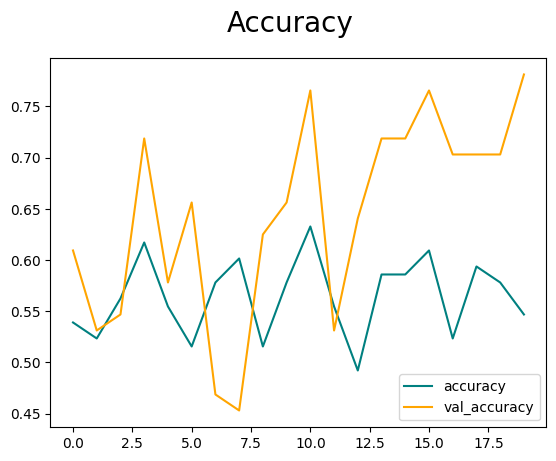

In [95]:
fig = plt.figure() #Creating the graph for accuracy

plt.plot(history.history["accuracy"], color = "teal", label= "accuracy")
plt.plot(history.history["val_accuracy"], color = "orange", label= "val_accuracy")
fig.suptitle("Accuracy", fontsize = 20)
plt.legend(loc = "lower right")
plt.show()

### Visualization of the results in the test data

A confusion matrix is a simple table that shows how well a classification model is performing by comparing its predictions to the actual results. It breaks down the predictions into four categories: correct predictions for both classes (true positives and true negatives) and incorrect predictions (false positives and false negatives).


Confusion Matrix


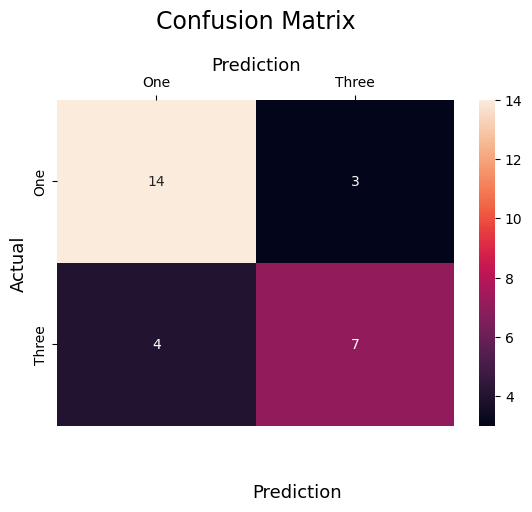

True Label: [1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0]
Predicted Label: [0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0]
              precision    recall  f1-score   support

         One       0.78      0.82      0.80        17
       Three       0.70      0.64      0.67        11

    accuracy                           0.75        28
   macro avg       0.74      0.73      0.73        28
weighted avg       0.75      0.75      0.75        28



In [96]:
#Confussion matrix for test results
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

labels = ["One","Three"] #Labels 

batch_test = test.as_numpy_iterator().next() #Allocating the test data to an array. Batch[0] equals to images while Batch[1] equals to true labels of the images

Y_pred = model.predict(batch_test[0]) #Makes predictions using test data
y_pred = (Y_pred > 0.5).astype(int).flatten() #If the prediction is smaller than 0.5 assigns 0 otherwise assigns to 1.

print('Confusion Matrix')
cm = confusion_matrix(batch_test[1], y_pred)# Creating the confusion matrix: Parameters are, true labels and predicted labels.

#Visualizing the confusion matrix
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['One','Three'],
            yticklabels=['One','Three'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()
print(f"True Label: {batch_test[1]}")
print(f"Predicted Label: {y_pred}")
print(classification_report(batch_test[1], y_pred, target_names = labels))

Evaluate the model on the test set and visualize the loss and accuracy in a bar chart.

1/1 [==============================] - 0s 152ms/step - loss: 0.2924 - accuracy: 0.6429
Test Loss: 0.29240432381629944
Test Accuracy: 0.6428571343421936


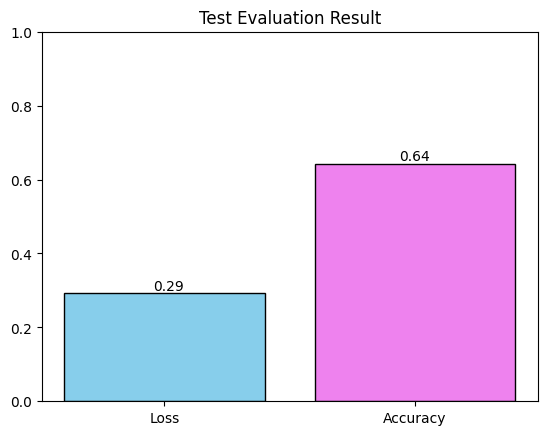

In [140]:
batch_test = test.as_numpy_iterator().next()

loss, accuracy = model.evaluate(batch_test[0],batch_test[1])
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

plt.bar("Loss", loss, color='skyblue', edgecolor='black')
plt.text(0.03 / 2, loss,  #Position the text
             f'{loss:.2f}', ha='center', va='bottom', fontsize=10)  # ormat the value to 2 decimal places
plt.bar("Accuracy", accuracy, color='violet', edgecolor='black')
plt.text(2 / 2, accuracy,  #Position the text
             f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)  #Format the value to 2 decimal places

plt.title('Test Evaluation Result')
plt.ylim(0, 1.0)
plt.show()

The visualization of the test batch and the predictions the model made for each image.

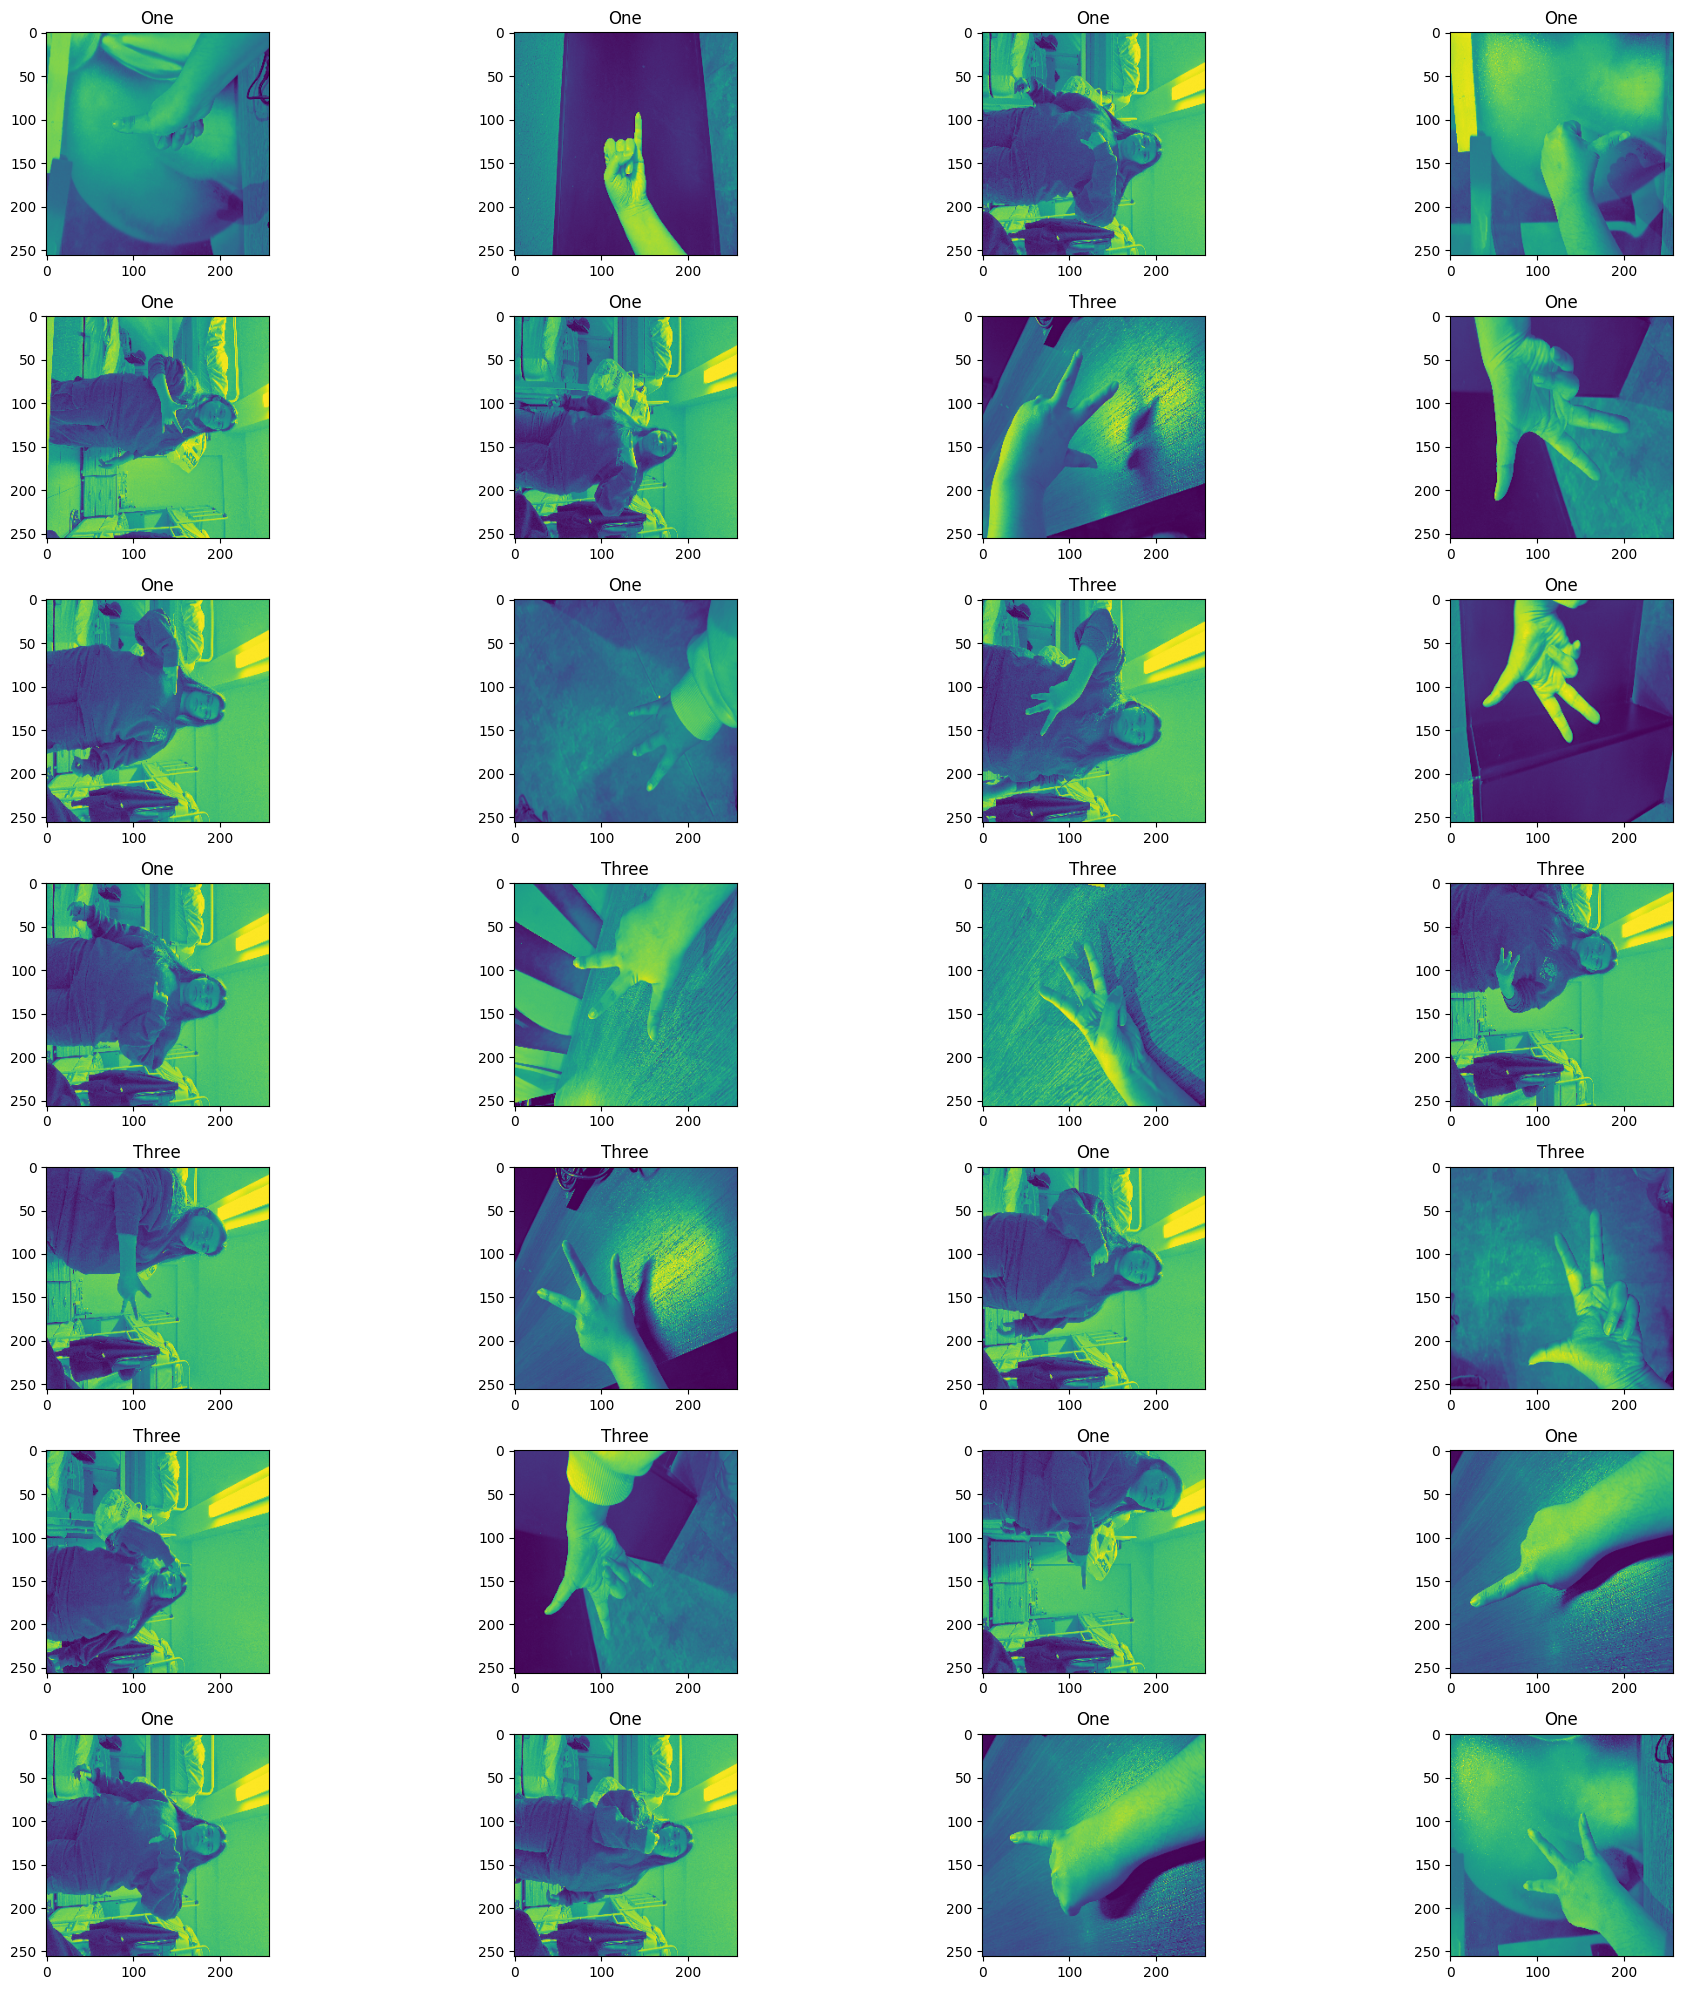

In [98]:
#Showing the test result and the predictions
batch = test.as_numpy_iterator().next()

Y_pred = model.predict(batch[0])
y_pred = (Y_pred > 0.5).astype(int).flatten()
fig,ax = plt.subplots(nrows = 7, ncols = 4, figsize = (20,20))

ax = ax.ravel()

for idx, img in enumerate(batch[0][:]):
    ax[idx].imshow(img)
    if y_pred[idx] == 1:
        ax[idx].title.set_text("Three")
    elif y_pred[idx] == 0:
        ax[idx].title.set_text("One")
plt.tight_layout()
plt.show()

Saving the model

In [99]:
from tensorflow.keras.models import load_model
model.save(os.path.join("models", "classifiermodel.h5"))


# Transfer Learning Model (MobileNet2)

Taking the images from the directory and separate them to train, val and test batches

In [115]:
data = tf.keras.utils.image_dataset_from_directory("data")
data = data.map(lambda x, y: (x/255, y)) #Resize the images

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])
def augment_images(x, y):
    x = data_augmentation(x)  # Apply augmentation
    return x, y

data = data.map(augment_images)
batch = data.as_numpy_iterator().next()

train_size = int(len(data)*.6)
validation_size = int(len(data)*.3)
test_size = int(len(data)*.1)+1

train_transfer = data.take(train_size)
val_transfer = data.skip(train_size).take(validation_size)
test_transfer = data.skip(train_size + validation_size).take(test_size)


Found 220 files belonging to 2 classes.


Transfer learning is a machine learning technique in which knowledge gained through one task or dataset is used to improve model performance on another related task and/or different dataset. In other words, transfer learning uses what has been learned in one setting to improve generalization in another setting. 

For this model, MobileNetV2 is selected as the pre-trained model. MobileNetV2 is a powerful and efficient convolutional neural network architecture designed for mobile and embedded vision applications. Because the dataset for this task is small, the model tends to overfit, and using a pre-trained model like MobileNetV2 helps mitigate this risk. MobileNetV2 significantly reduces the number of parameters and computational costs through the use of depthwise separable convolutions, and the inverted residual blocks further prevent the model from overfitting.

In [127]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import BatchNormalization

pre_trained = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3))

for layer in pre_trained.layers: #Freze the layers of pre-trained model
        layer.trainable=False
for layer in pre_trained.layers[-10:]: #Unfreezes only the last 10 layers of the pre-trained model, allowing their weights to be updated during training.
    layer.trainable = True    

transfer_model = Sequential()

transfer_model.add(pre_trained)
transfer_model.add(Flatten())

transfer_model.add(Dense(32, activation= "relu", kernel_regularizer=regularizers.l2(0.01)))
transfer_model.add(BatchNormalization())
transfer_model.add(Dropout(0.3))

transfer_model.add(Dense(16, activation= "relu", kernel_regularizer=regularizers.l2(0.01)))
transfer_model.add(Dropout(0.2))

transfer_model.add(Dense(1, activation= "sigmoid", kernel_regularizer=regularizers.l2(0.01)))

transfer_model.compile("adam", loss = tf.losses.BinaryFocalCrossentropy(), metrics = ["accuracy"])

transfer_model.summary()

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_20 (Flatten)        (None, 81920)             0         
                                                                 
 dense_46 (Dense)            (None, 32)                2621472   
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dropout_40 (Dropout)        (None, 32)                0         
                                                                 
 dense_47 (Dense)            (None, 16)              

Training the model on training dataset and validation dataset.

In [128]:
log_dir = "logs/TransferLearning" 
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

history_transfer = transfer_model.fit(train_transfer, epochs = 20, validation_data = val_transfer, callbacks = [tensorboard_callback, early_stopping])

Epoch 1/20
4/4 [==============================] - 6s 600ms/step - loss: 1.3212 - accuracy: 0.5859 - val_loss: 24.4627 - val_accuracy: 0.5312
Epoch 2/20
4/4 [==============================] - 2s 455ms/step - loss: 1.0606 - accuracy: 0.7500 - val_loss: 24.5431 - val_accuracy: 0.3750
Epoch 3/20
4/4 [==============================] - 2s 453ms/step - loss: 1.0754 - accuracy: 0.7969 - val_loss: 18.1370 - val_accuracy: 0.4219
Epoch 4/20
4/4 [==============================] - 2s 451ms/step - loss: 1.0877 - accuracy: 0.8750 - val_loss: 13.2807 - val_accuracy: 0.4688
Epoch 5/20
4/4 [==============================] - 2s 446ms/step - loss: 1.0688 - accuracy: 0.9219 - val_loss: 8.9826 - val_accuracy: 0.5625
Epoch 6/20
4/4 [==============================] - 2s 441ms/step - loss: 1.0308 - accuracy: 0.9609 - val_loss: 7.3365 - val_accuracy: 0.5625
Epoch 7/20
4/4 [==============================] - 3s 439ms/step - loss: 0.9966 - accuracy: 0.9531 - val_loss: 6.7724 - val_accuracy: 0.5156
Epoch 8/20
4/4 [

Graphs of loss and accuracy for the training data and validation data

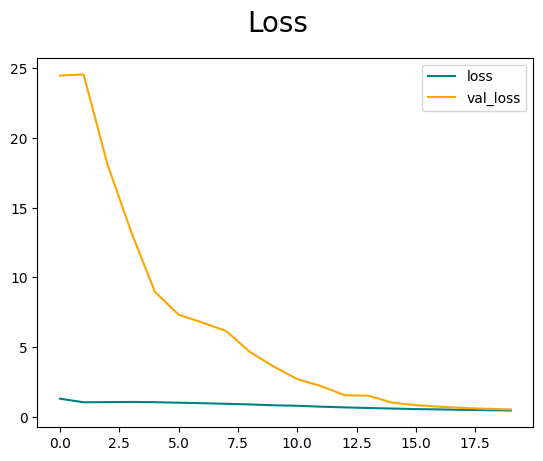

In [129]:
fig = plt.figure()

plt.plot(history_transfer.history["loss"], color = "teal", label= "loss")
plt.plot(history_transfer.history["val_loss"], color = "orange", label= "val_loss")
fig.suptitle("Loss", fontsize = 20)
plt.legend(loc = "upper right")
plt.show()

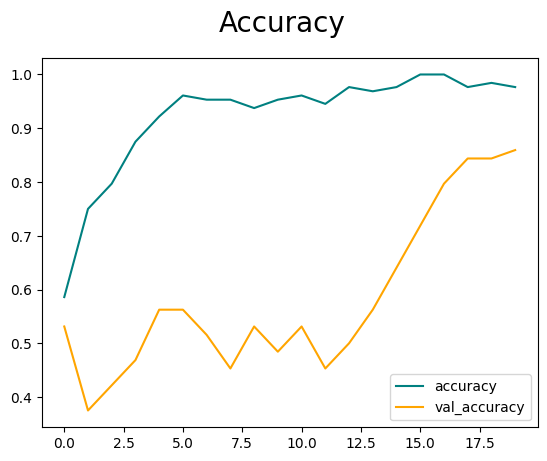

In [130]:
fig = plt.figure()

plt.plot(history_transfer.history["accuracy"], color = "teal", label= "accuracy")
plt.plot(history_transfer.history["val_accuracy"], color = "orange", label= "val_accuracy")
fig.suptitle("Accuracy", fontsize = 20)
plt.legend(loc = "lower right")
plt.show()

### Visualization of the results in the test data

Confusion Matrix


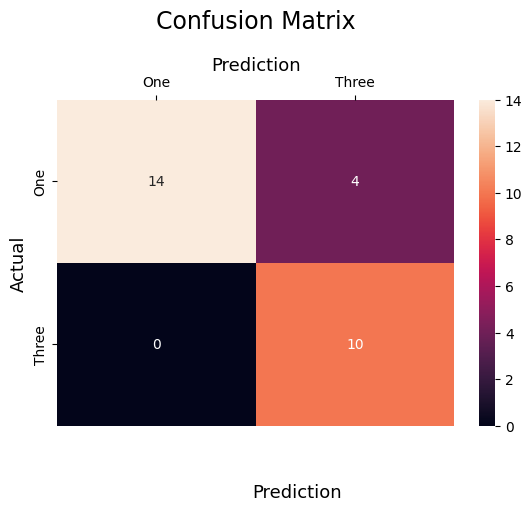

True Label: [0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0]
Predicted Label: [0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0]
              precision    recall  f1-score   support

         One       1.00      0.78      0.88        18
       Three       0.71      1.00      0.83        10

    accuracy                           0.86        28
   macro avg       0.86      0.89      0.85        28
weighted avg       0.90      0.86      0.86        28



In [131]:
#Confussion matrix for test results
labels = ["One","Three"]

batch_test = test_transfer.as_numpy_iterator().next()

Y_pred = transfer_model.predict(batch_test[0])
y_pred = (Y_pred > 0.5).astype(int).flatten()

print('Confusion Matrix')
cm = confusion_matrix(batch_test[1], y_pred )

sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['One','Three'],
            yticklabels=['One','Three'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()

plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()
print(f"True Label: {batch_test[1]}")
print(f"Predicted Label: {y_pred}")
print(classification_report(batch_test[1], y_pred, target_names = labels))

1/1 [==============================] - 0s 259ms/step - loss: 0.5645 - accuracy: 0.8929
Test Loss: 0.5645232200622559
Test Accuracy: 0.8928571343421936


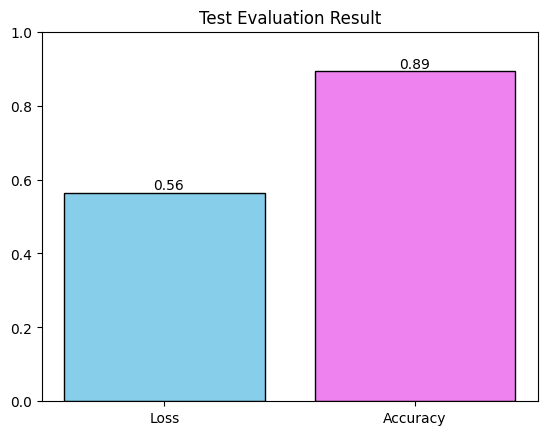

In [135]:
batch_test = test_transfer.as_numpy_iterator().next()

loss, accuracy = transfer_model.evaluate(batch_test[0],batch_test[1])
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


plt.bar("Loss", loss, color='skyblue', edgecolor='black')
plt.text(0.03 / 2, loss,  #Position the text
             f'{loss:.2f}', ha='center', va='bottom', fontsize=10)  # ormat the value to 2 decimal places
plt.bar("Accuracy", accuracy, color='violet', edgecolor='black')
plt.text(2 / 2, accuracy,  #Position the text
             f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)  #Format the value to 2 decimal places
plt.title('Test Evaluation Result')
plt.ylim(0, 1.0)
plt.show()

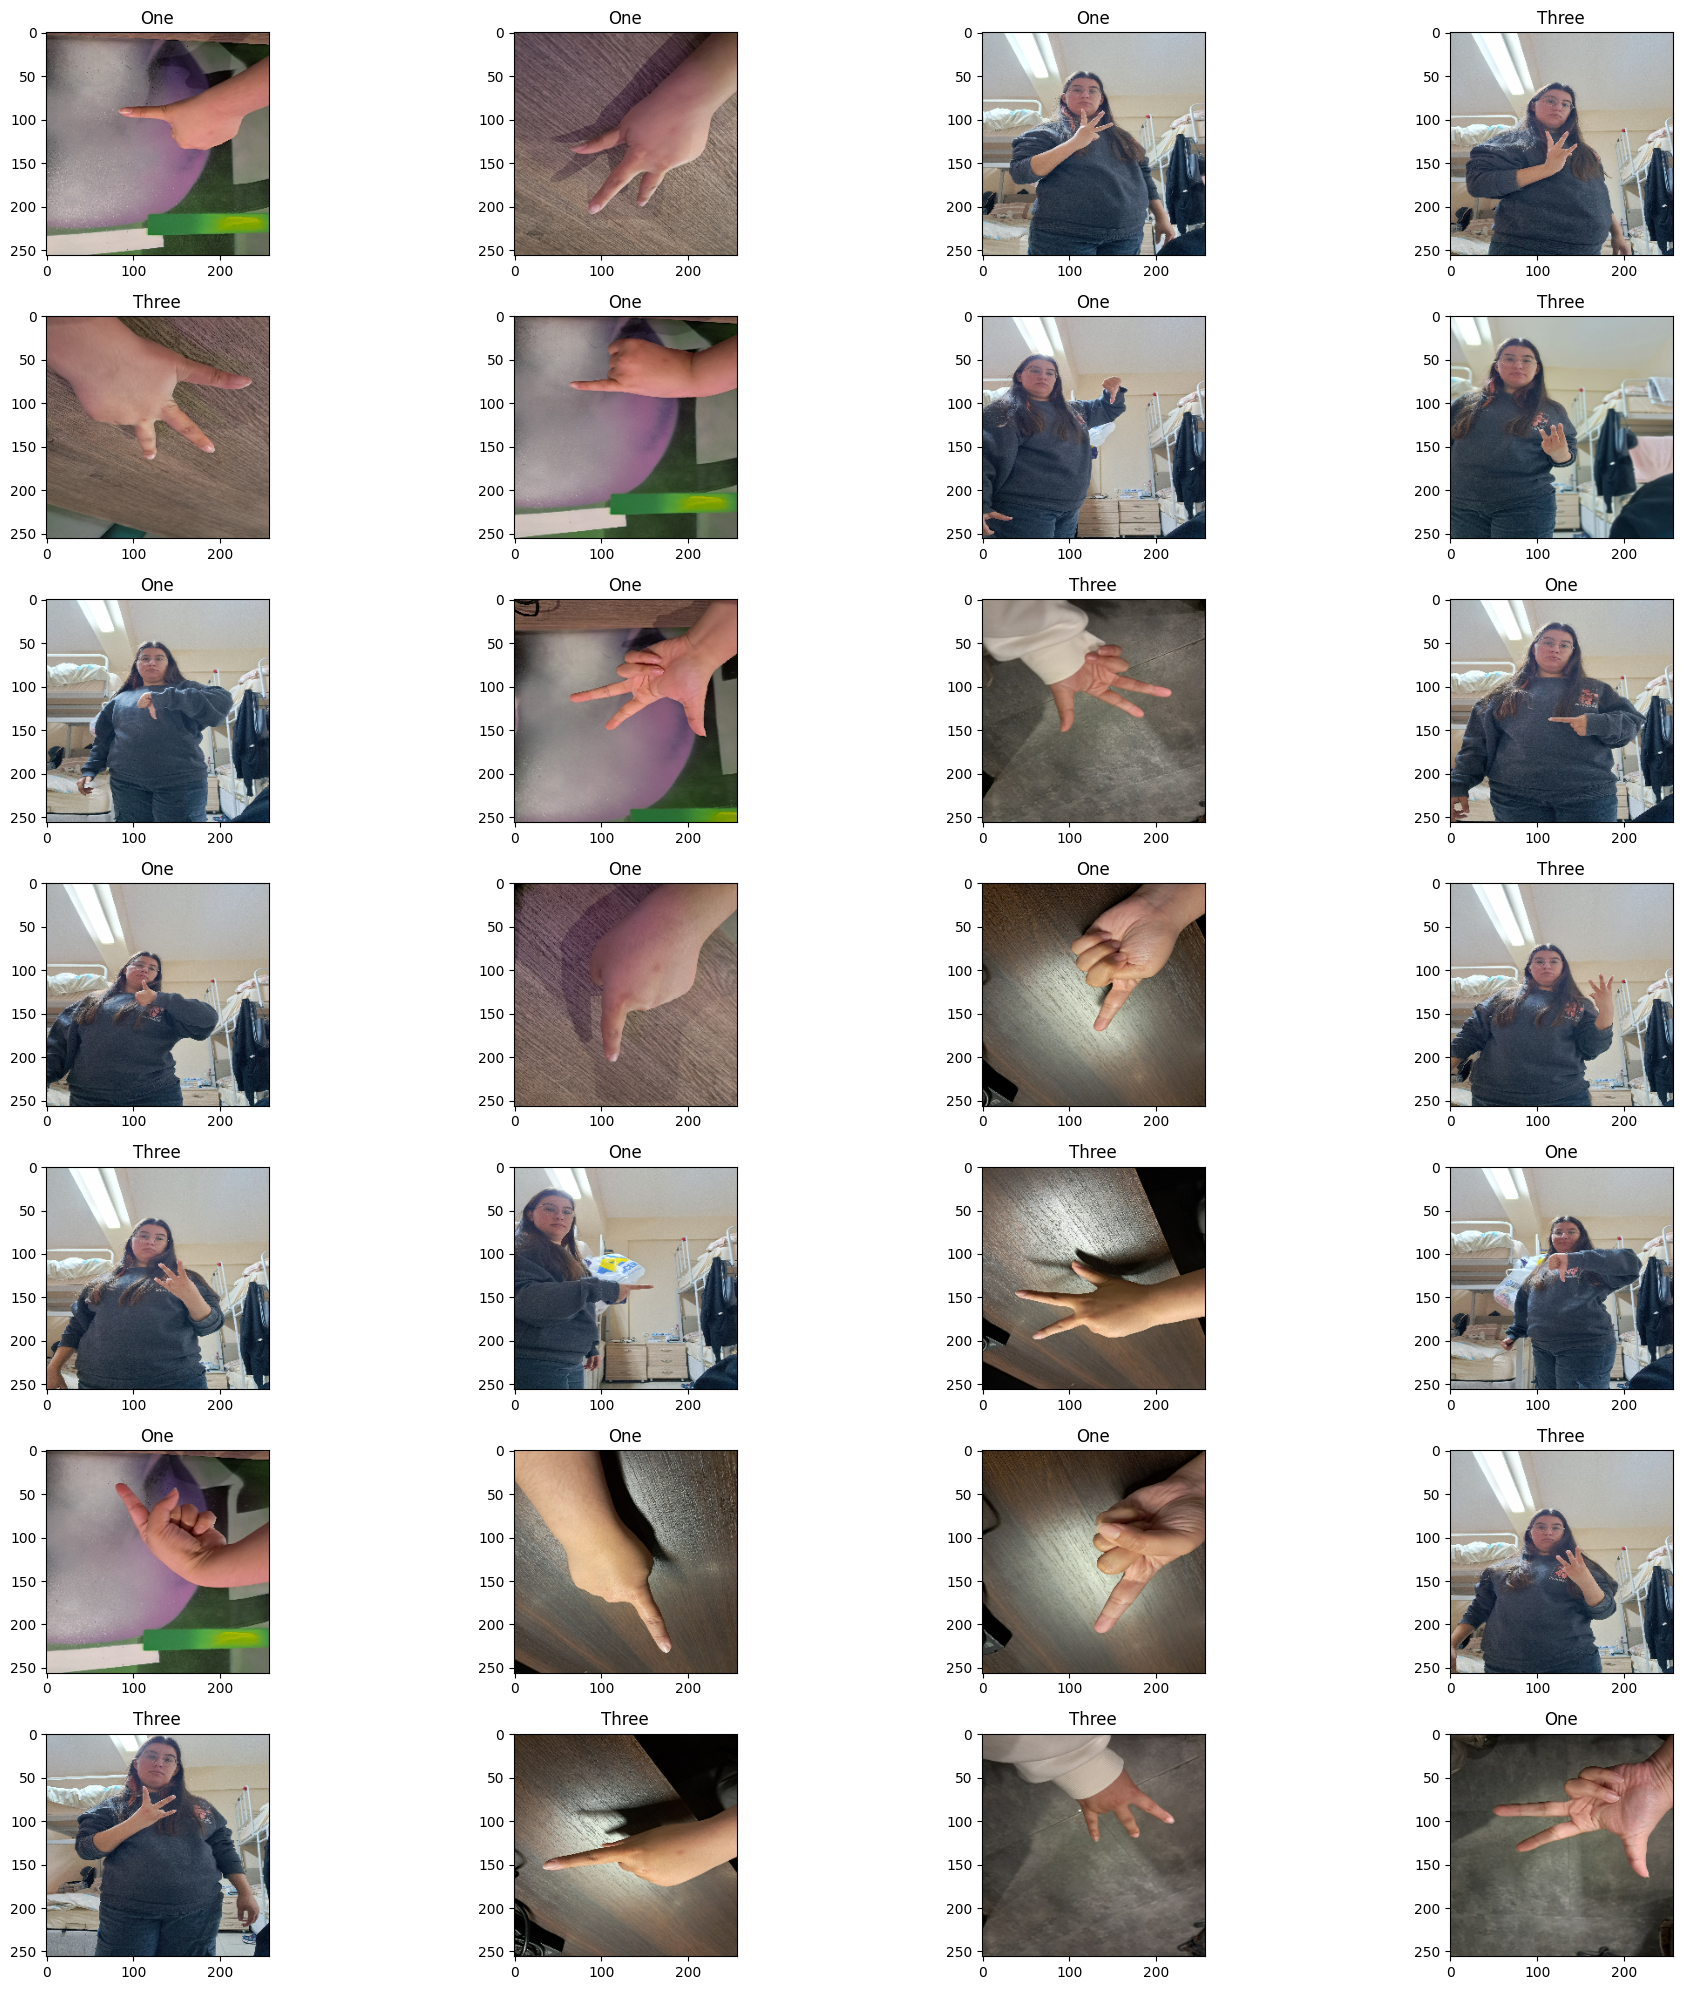

In [470]:
#Showing the test result and the predictions
batch = test_transfer.as_numpy_iterator().next()

Y_pred = transfer_model.predict(batch[0])
y_pred = (Y_pred > 0.5).astype(int).flatten()
fig,ax = plt.subplots(nrows = 7, ncols = 4, figsize = (20,20))

ax = ax.ravel()

for idx, img in enumerate(batch[0][:]):
    ax[idx].imshow(img)
    if y_pred[idx] == 1:
        ax[idx].title.set_text("Three")
    elif y_pred[idx] == 0:
        ax[idx].title.set_text("One")
plt.tight_layout()
plt.show()